# Heat equation in 2D: joint estimation of the solution and the diffusion 

This is a **jinns** reimplementation of the inverse problem studied in [this article](https://arxiv.org/pdf/2306.08827.pdf) for example, the original code is available [here](https://github.com/i207M/PINNacle/blob/main/src/pde/inverse.py#L58).

Consider the following PDE on $\Omega=[0,1]^2$:
$$
\begin{cases}
\frac{\partial}{\partial t}u(x,y)-\nabla(a(x,y)\nabla u(x,y)) = f(x, y),\\
f(x,y)=((4\pi^2-1)\sin\pi x\sin\pi y + \pi^2(2\sin^2\pi x\sin^2\pi y-\cos^2\pi \sin^2 \pi y - \sin^2\pi x\cos^2\pi y))e^{-t}, \text{ (source term)}.
\end{cases}
$$
On the boundary $\partial\Omega$ we set
$$
a(x,y) = 2.
$$

We get that the true solution on $\Omega$ that we will estimate with a PINN is 
$$
u(x,y)=e^{-t}\sin\pi x\sin\pi y.
$$
The ground truth on $\Omega$ of the diffusion coefficient is
$$
a(x,y) = 2+\sin\pi x\sin\pi y.
$$



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns


Import other dependencies

In [3]:
import jax
import numpy as np
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt
import time
key = random.PRNGKey(2)
key, subkey = random.split(key)

2024-10-08 09:54:00.529738: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Observations

We simulate some observations

In [4]:
def u_true(t, x):
    return jnp.exp(-t) * jnp.sin(jnp.pi * x[0]) * jnp.sin(jnp.pi * x[1])
v_u_true = vmap(u_true)

In [5]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 2), minval=-1.0, maxval=1.0)
t = jax.random.uniform(subkey, shape=(n_obs, 1), minval=0.0, maxval=1.0)
obs = v_u_true(t, x)

obs_batch = jnp.concatenate([
    t[..., 0:1], x[..., 0:2], obs
    ], axis=-1)

__Optionally blur the observed values__

In [6]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 3].set(
    obs_batch[:, 3] +
    0 #random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)

Create the neural network architecture for the PINN. The network will have two outputs:

- $u(x,y)$, the classical PINN output
- $a(x, y)$. This secondary PINN output should then be treated as the diffusion coefficient, i.e., an equation parameter. However, in **jinns** equation parameters are fed through the dictionary `Params.eq_params`. Thus, in order to feed the second PINN output to the dictionnary, one needs to specify a transform using the `eq_params_heterogeneity` argument. We discuss this in more details in below in the loss construction section.

In [7]:
eqx_list = (
    (eqx.nn.Linear, 3, 50), # 3 = t + x (2D)
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 2)
)

key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2, slice_solution=jnp.s_[:1])
init_sol_nn_params = u.init_params()

> **Note:** The following cell provides an approach to perform the same estimation with two parallel PINNs $u_{\nu_u}(t, x)$ and $a_{\nu_a}(x)$ that are then joined with a custom `concatPINN` class to comply with **jinns** inner mechanics. However, we do not use this approach since we found out that the optimization is much longer and harder to perform.

In [8]:
# eqx_list = (
#     (eqx.nn.Linear, 3, 50), # 3 = t + x (2D)
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 50),
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 50),
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 1)
# )

# key, subkey = random.split(key)
# sol_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)
# init_sol_nn_params = sol_pinn.init_params()
# eqx_list = (
#     (eqx.nn.Linear, 3, 50), # 3 = t + x (2D)
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 50),
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 50),
#     (jax.nn.tanh,),
#     (eqx.nn.Linear, 50, 2)
# )

# key, subkey = random.split(key)
# a_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)
# init_a_nn_params = a_pinn.init_params()

# from jinns.utils._pinn import PINN

# class concatPINN(PINN):

#     def __init__(self, pinn_dict, slice_solution):
#         self.pinn_dict = pinn_dict
#         self.slice_solution = slice_solution

#     def __call__(self, t, x, params):
#         res = []
#         for name, u_ in self.pinn_dict.items():
#             if u_.eq_type == "ODE":
#                 res.append(u_(t, params["nn_params"][name]))
#             elif u_.eq_type == "statio_PDE":
#                 res.append(u_(x, params["nn_params"][name]))
#             elif u_.eq_type == "nonstatio_PDE":
#                 res.append(u_(t, x, params["nn_params"][name]))

#         return jnp.concatenate(jnp.array(res), axis=-1) # note that the order in pinn_dict is important here

# u = concatPINN({"sol":sol_pinn, "a":a_pinn}, slice_solution=jnp.s_[:1])
# init_params = jinns.parameters.ParamsDict(
#     nn_params={"sol":init_sol_nn_params, "a":init_a_nn_params},
#     eq_params"={
#         "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
#     }
# )

In [9]:
init_params = jinns.parameters.Params(
    nn_params = init_sol_nn_params,
    eq_params = {
        "a":0. # The second output of the PINN will correspond to the diffusion coefficient, so the value here is irrelevant
    }
)

Create a DataGenerator object

In [10]:
n = 5000
nt = 5000
nb = 3200
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin, xmin),
    max_pts=(xmax, xmax),
    tmin=tmin,
    tmax=tmax,
    method=method
)


Create the DataGenerator for observations

In [11]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    omega_batch_size * temporal_batch_size,
    observed_pinn_in=obs_batch[:, 0:3],
    observed_values=obs_batch[:, 3:4]
)

## Loss construction

We turn to the implementation if the 2D Heat loss. 

Importantly, the loss contains **heterogeneous parameters** (*i.e.* which possibly depends on `t`, `x` and `params`). This can be managed by defining a dictionary `eq_params_heterogeneity` where keys match the ones in `Params.eq_params`, and values can be by any kind of jit-able function that returns equation parameters. 

Here, the diffusion parameter (`Params.eq_params["a"]`) is defined to be the second output of the whole network. Thus, we simply design a custom transform function set to key `"a"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the signature of such a function must be `t, x, u, params` in the non-stationary case we are dealing with here.

The rest of the implementation is as-usal in **jinns** : we define the `eqx.Module` subclassing `PDENonStatio` with its `equation` method. The parameters heterogeneity will be handled internally by the package.

In [12]:
def a_to_pinn_output(t, x, u, params):
    """
    A jittable function that attributes the second output of u to the diffusion coefficient `a`.
    """
    return u(t, x, params)[1]
eq_params_heterogeneity = {"a": a_to_pinn_output}

In [13]:
from jinns.loss import PDENonStatio

class HeatLoss2D(PDENonStatio):
    def __init__(self, eq_params_heterogeneity):
        super().__init__(eq_params_heterogeneity=eq_params_heterogeneity)

    def equation(self, t, x, u, params):
        # Because we passed some eq_params_heterogeneity
        # params we receive are already modified with the user defined
        # eq_params_heterogeneity
        u_pinn = lambda t, x, params: jnp.squeeze(u(t, x, params)[u.slice_solution]) # Grab the slice corresponding to solution (jnp.s_[0:1])
        def source_term(t, x, params):
            # does not depend on `params` here, but could so we let it.
            x, y = x[0], x[1]
            return (
                ((4 * jnp.pi ** 2 - 1) * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) +
                     jnp.pi ** 2 * (2 * jnp.sin(jnp.pi * x) ** 2 * jnp.sin(jnp.pi * y) ** 2 -
                        jnp.cos(jnp.pi * x) ** 2 * jnp.sin(jnp.pi * y) ** 2 -
                        jnp.sin(jnp.pi * x) ** 2 * jnp.cos(jnp.pi * y) ** 2)
                ) * jnp.exp(-t)
            )
        a_times_jac_u = lambda t, x, params: params.eq_params["a"] * jax.jacrev(u_pinn, 1)(t, x, params)
        return (jax.grad(u_pinn, 0)(t, x, params)
                - jinns.loss._operators._div_rev(t, x, a_times_jac_u, params)
                - source_term(t, x, params)
               )

In [14]:
heat_loss = HeatLoss2D(
    eq_params_heterogeneity=eq_params_heterogeneity
)

Create the boundary function and the global loss

In [15]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1.,
    boundary_loss=10.,
    observations=10.
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=heat_loss,
    omega_boundary_fun=lambda t, dx: 2.,
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1], # the second output of the ConcatPINN is the one with enforced boundary condition
    params=init_params
)


/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:570: UserWarning: Initial condition wasn't provided. Be sure to cover for thatcase (e.g by. hardcoding it into the PINN output).
  warnings.warn(


In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, colloc_batch = train_data.get_batch()
obs_data, obs_batch = obs_data.get_batch()

losses, grads = losses_and_grad(
    init_params,
    batch = jinns.data.append_obs_batch(
        colloc_batch,
        obs_batch
    )
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 323.32
Individual losses: {'boundary_loss': '178.11', 'dyn_loss': '144.02', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '1.19'}


## Joint estimation of `a(x,y)` and `nn_params`

In [17]:
params = init_params

Below we can test either the alternating optimizer or the delayed optimizer provided by `jinns` to alter the optimization process whether we consider the PINN parameters or the equation parameters.

In [18]:
import optax
n_iter = 200000
tx = optax.adam(learning_rate=1e-3)

Then optimization starts

In [19]:
key, subkey = random.split(key, 2)
start = time.time()
params, total_loss_list, loss_by_term_dict, train_data, loss, _, tracked_params , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    print_loss_every=10000,
    obs_data=obs_data
)
end = time.time()

[train] Iteration 0: loss value = 407.5811462402344
[train] Iteration 10000: loss value = 0.08988417685031891
[train] Iteration 20000: loss value = 0.08859270811080933
[train] Iteration 30000: loss value = 0.0693570077419281
[train] Iteration 40000: loss value = 0.04898800328373909
[train] Iteration 50000: loss value = 0.04370003193616867
[train] Iteration 60000: loss value = 0.08834685385227203
[train] Iteration 70000: loss value = 0.16703328490257263
[train] Iteration 80000: loss value = 0.02499426156282425
[train] Iteration 90000: loss value = 0.024785982444882393
[train] Iteration 100000: loss value = 0.05971432477235794
[train] Iteration 110000: loss value = 0.02107398398220539
[train] Iteration 120000: loss value = 0.06546644866466522
[train] Iteration 130000: loss value = 0.02755075693130493
[train] Iteration 140000: loss value = 0.02077513001859188
[train] Iteration 150000: loss value = 0.054167598485946655
[train] Iteration 160000: loss value = 0.024960044771432877
[train] Ite

In [20]:
time_training = end - start
print("Time training", time_training)

Time training 916.6313855648041


## Results

Plot the loss values

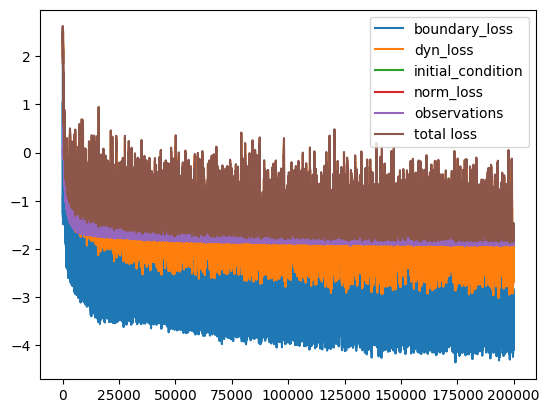

In [21]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()


# Plot the PDE solutions learned by the PINN

## Plot of u(t, x, params)

Solution : u(t, x)


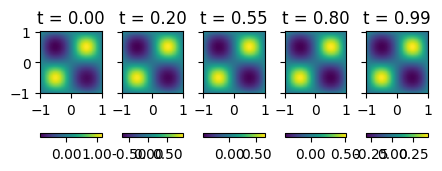

In [22]:
u_est = lambda t, x: u(t, x, params)[0]
nx = 200
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
times = [0, 0.2, 0.55, 0.8, 0.99] # times in the rescaled time susescale

jinns.plot.plot2d(u_est, xy_data=val_xydata, times=times, cmap="viridis", figsize=(5, 5))
print("Solution : u(t, x)")

Ground truth: u_true(t, x)


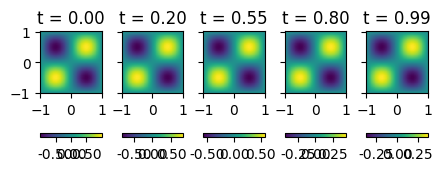

In [23]:
jinns.plot.plot2d(u_true, xy_data=val_xydata, times=times, cmap="viridis", figsize=(5, 5))
print("Ground truth: u_true(t, x)")

Difference: u_true(t, x) - u_est(t, x)


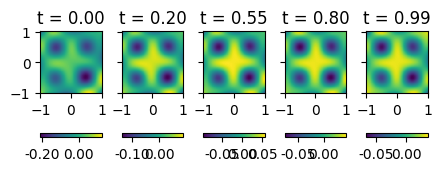

In [24]:
u_diff = lambda t, x: u_true(t, x) - u_est(t, x)
jinns.plot.plot2d(u_diff, xy_data=val_xydata, times=times, cmap="viridis", figsize=(5, 5))
print("Difference: u_true(t, x) - u_est(t, x)")

## Plot of the coefficients a(x, y)

> **Note** that the estimated network for $a$ do depend on $t$ but the solution learnt is invariant for $t \in I$.

Estimated coefficient : a(x, y)


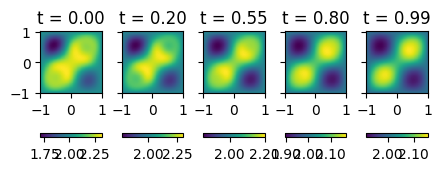

In [25]:
a_est = lambda t, x: u(t, x, params)[1]
jinns.plot.plot2d(a_est, xy_data=val_xydata, times=times, cmap="viridis", figsize=(5, 5))
print("Estimated coefficient : a(x, y)")

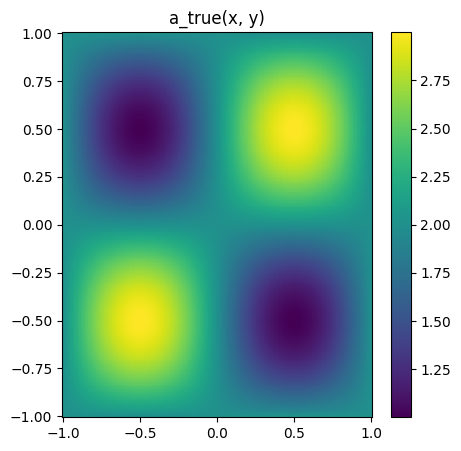

In [26]:
def a_true(x):
    x, dy = x[0], x[1]
    return 2 + jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * dy)

val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(a_true, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a_true(x, y)")

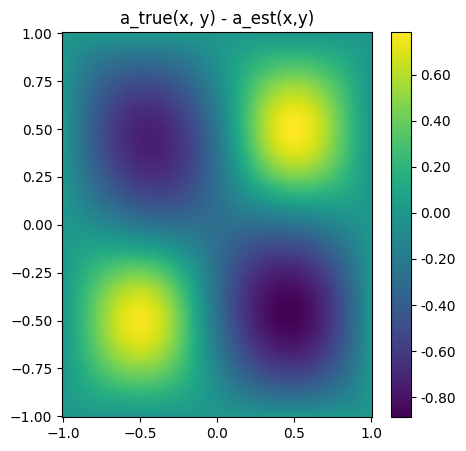

In [27]:
# quick-and-dirty estimator of a(x,y) by averaging on the `t` axis.
# another solution could be to freeze t to some value in [0, 1].
a_diff = lambda x: a_true(x) - jnp.mean(vmap(lambda t: a_est(t, x), 0, 0)(jnp.arange(0, 1, 100)[None, ...]))
jinns.plot.plot2d(a_diff, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a_true(x, y) - a_est(x,y)")

## Conclusion

The results have been computed around 15 minutes on a Nvidia T600 GPU. Specific finetuning and longer training are required for more precise results.